In [1]:
# 0-10 : KRAS, 11-21: EGFR, 22-32: ROS1
nct_ids = ['NCT02964689',
'NCT07020221',
'NCT06385925',
'NCT06936644',
'NCT05786924',
'NCT05737706',
'NCT05347797',
'NCT06607185',
'NCT06497556',
'NCT05480865',
'NCT06599502',
'NCT04912687',
'NCT06595498',
'NCT02769286',
'NCT04552613',
'NCT06071013',
'NCT03755102',
'NCT05166616',
'NCT02926768',
'NCT02504346',
'NCT06924398',
'NCT06043817',
'NCT04084717',
'NCT05845671',
'NCT01639508',
'NCT06315010',
'NCT04621188',
'NCT05681780',
'NCT05351320',
'NCT07110259',
'NCT04042558',
'NCT03721120',
'NCT04777084']

# List of gene mutations : KRAS for first 11, EGFR for next 11, ROS1 for last 11
gene_mutations = ['KRAS' for _ in range(11)] + \
                    ['EGFR' for _ in range(11)] + \
                    ['ROS1' for _ in range(11)]

In [2]:
gene_mutations

['KRAS',
 'KRAS',
 'KRAS',
 'KRAS',
 'KRAS',
 'KRAS',
 'KRAS',
 'KRAS',
 'KRAS',
 'KRAS',
 'KRAS',
 'EGFR',
 'EGFR',
 'EGFR',
 'EGFR',
 'EGFR',
 'EGFR',
 'EGFR',
 'EGFR',
 'EGFR',
 'EGFR',
 'EGFR',
 'ROS1',
 'ROS1',
 'ROS1',
 'ROS1',
 'ROS1',
 'ROS1',
 'ROS1',
 'ROS1',
 'ROS1',
 'ROS1',
 'ROS1']

In [2]:
import os

os.chdir('/scratch/mgeorges/TrialMatchAI/TrialMatchAI/data/cluster_trials')
# Search for the IDs in processed_trials and open the jsons
def find_json_files(nct_ids, directory):
    json_files = []
    for nct_id in nct_ids:
        filename = f"{nct_id}.json"
        file_path = os.path.join(directory, filename)
        if os.path.exists(file_path):
            json_files.append(file_path)
        else:
            print(f"File {filename} not found in {directory}")
    return json_files

# Directory where the JSON files are stored
directory = './'
# Find the JSON files
json_files = find_json_files(nct_ids, directory)
# Print the found JSON files
print(json_files)

['./NCT02964689.json', './NCT07020221.json', './NCT06385925.json', './NCT06936644.json', './NCT05786924.json', './NCT05737706.json', './NCT05347797.json', './NCT06607185.json', './NCT06497556.json', './NCT05480865.json', './NCT06599502.json', './NCT04912687.json', './NCT06595498.json', './NCT02769286.json', './NCT04552613.json', './NCT06071013.json', './NCT03755102.json', './NCT05166616.json', './NCT02926768.json', './NCT02504346.json', './NCT06924398.json', './NCT06043817.json', './NCT04084717.json', './NCT05845671.json', './NCT01639508.json', './NCT06315010.json', './NCT04621188.json', './NCT05681780.json', './NCT05351320.json', './NCT07110259.json', './NCT04042558.json', './NCT03721120.json', './NCT04777084.json']


In [3]:
# Read the JSON files and print their content
import json
def read_json_files(json_files):
    json_contents = []
    for file_path in json_files:
        with open(file_path, 'r') as file:
            content = json.load(file)
            json_contents.append(content)
    return json_contents

# Get the dictionary keys from the first JSON file
def get_unique_json_keys(json_contents):
    if json_contents:
        keys = set()
        for content in json_contents:
            keys.update(content.keys())
        return list(keys)
    else:
        print("No JSON contents to process.")
    return []

json_contents = read_json_files(json_files)
json_keys = get_unique_json_keys(json_contents)
json_keys

['derivedSection', 'hasResults', 'protocolSection']

In [4]:
# Show NCT07020221 keys
for nct_id in nct_ids:
    nct_file = f"{nct_id}.json"
    with open(nct_file, 'r') as file:
        nct_content = json.load(file)
    # Print the keys of the specific NCT ID
    print(f"Keys for {nct_id}:")
    print(nct_content.keys())

    # Print the content of the specific NCT ID
    print(f"Content for {nct_id}:")
    print(nct_content)

Keys for NCT02964689:
dict_keys(['protocolSection', 'derivedSection', 'hasResults'])
Content for NCT02964689:
{'protocolSection': {'identificationModule': {'nctId': 'NCT02964689', 'orgStudyIdInfo': {'id': 'SAKK 19/16'}, 'organization': {'fullName': 'Swiss Cancer Institute', 'class': 'OTHER'}, 'briefTitle': 'Binimetinib in Addition to Standard Chemotherapy in KRAS Mutated NSCLC.', 'officialTitle': 'Binimetinib, Pemetrexed and Cisplatin, Followed by Maintenance With Binimetinib and Pemetrexed, in Patients With Advanced Non-small Cell Lung Cancer NSCLC With KRAS Mutations. A Multicenter Phase IB Trial.'}, 'statusModule': {'statusVerifiedDate': '2021-07', 'overallStatus': 'COMPLETED', 'expandedAccessInfo': {'hasExpandedAccess': False}, 'startDateStruct': {'date': '2017-04-12', 'type': 'ACTUAL'}, 'primaryCompletionDateStruct': {'date': '2021-07-02', 'type': 'ACTUAL'}, 'completionDateStruct': {'date': '2021-07-02', 'type': 'ACTUAL'}, 'studyFirstSubmitDate': '2016-11-14', 'studyFirstSubmitQcD

In [5]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from sklearn.neighbors import NearestNeighbors

from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np

# Load the BiomedBERT model and tokenizer
model_name = "/scratch/mgeorges/TrialMatchAI/TrialMatchAI/models/models/biomedner_multi"
tokenizer = AutoTokenizer.from_pretrained(model_name, local_files_only=True)
model = AutoModel.from_pretrained(model_name, local_files_only=True)

# Load model and tokenizer
""" model_name = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name) """

# Function to encode text into embeddings
def encode_text(text, tokenizer, model):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    # Mean pooling to get a single embedding vector
    embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
    return embeddings

def encode_text_with_sliding_window(text, tokenizer, model, max_length=512, stride=256):
    # Tokenize the text into chunks
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=max_length,
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=False,
    )
    
    # Extract only the relevant inputs for the model
    input_ids = inputs["input_ids"]
    attention_mask = inputs["attention_mask"]

    # Process each chunk and aggregate embeddings
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    
    # Mean pooling across all chunks
    chunk_embeddings = outputs.last_hidden_state.mean(dim=1)  # Mean pooling for each chunk
    aggregated_embedding = chunk_embeddings.mean(dim=0).squeeze().numpy()  # Aggregate across chunks
    return aggregated_embedding

def preprocess_text(content):
    # Extract relevant fields
    if 'protocolSection' in content:
        content = content['protocolSection']
        if 'eligibilityModule' in content:
            eligibility = content['eligibilityModule'].get('eligibilityCriteria', '')
            conditions = content['conditionsModule'].get('condition', '')
            locations = content['eligibilityModule'].get('location', '')
            brief_title = content['identificationModule'].get('briefTitle', '')
            brief_summary = content['descriptionModule'].get('briefSummary', '')
            detailed_description = content['descriptionModule'].get('detailedDescription', '')
    else:
        eligibility = content.get('eligibility_criteria', '')
        conditions = content.get('condition', '')
        locations = content.get('location', '')
        brief_title = content.get('brief_title', '')
        brief_summary = content.get('brief_summary', '')

    # Check if any field is empty and print a warning
    if not (eligibility or conditions or brief_summary or detailed_description):
        print(f"Warning: No relevant fields found in content: {content}")
        if not brief_summary:
            brief_summary = "No brief summary provided."
        if not eligibility:
            eligibility = "No eligibility criteria provided."
        if not conditions:
            conditions = "No conditions provided."
        if not detailed_description:
            detailed_description = "No detailed description provided."

    # Concatenate fields into a single string
    combined_text = f"{brief_summary} {conditions}"
    return combined_text

def extract_vectors(json_contents):
    # Create vectors from eligibility criteria text
    enriched_vectors = []
    for idx, content in enumerate(json_contents):  # Assuming json_contents contains your trial data
        combined_text = preprocess_text(content)
        combined_text = gene_mutations[idx] * 3 + " " + combined_text  # Add gene mutation to the text
        embedding = encode_text_with_sliding_window(combined_text, tokenizer, model)
        enriched_vectors.append(embedding)

    return np.array(enriched_vectors)

# Step 2: Normalize vectors
def normalize_vectors(vectors):
    norms = np.linalg.norm(vectors, axis=1, keepdims=True)
    return vectors / norms

# Step 3: Perform KNN clustering
def knn_clustering(vectors, n_neighbors):
    knn = NearestNeighbors(n_neighbors=n_neighbors, metric='cosine')
    knn.fit(vectors)
    distances, indices = knn.kneighbors(vectors)
    return distances, indices

def kmeans_clustering(vectors, n_clusters, dbscan=False):
    # Add DBScan
    if dbscan:
        clustering = DBSCAN(eps=0.3, min_samples=10, metric='cosine')
        labels = clustering.fit_predict(vectors)
        return labels
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(vectors)
    return labels

# Step 4: Validate cluster tightness
def validate_cluster(distances, threshold=0.1):
    # Ensure all distances are below the threshold for a "tight" cluster
    return np.all(distances[:, 1:] < threshold)


/scratch/mgeorges/conda_envs/unsloth_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/scratch/mgeorges/conda_envs/unsloth_env/lib/python3.11/site-packages/transformers/utils/hub.py:105: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [6]:
def analyze_token_lengths(json_contents, tokenizer):
    lengths = []
    for content in json_contents:
        combined_text = preprocess_text(content)
        tokens = tokenizer(combined_text, truncation=False, return_tensors="pt")
        lengths.append(len(tokens['input_ids'][0]))
    return lengths

# Analyze token lengths
token_lengths = analyze_token_lengths(json_contents, tokenizer)
print(f"Max token length: {max(token_lengths)}")
print(f"Average token length: {np.mean(token_lengths)}")

Token indices sequence length is longer than the specified maximum sequence length for this model (580 > 512). Running this sequence through the model will result in indexing errors


Max token length: 580
Average token length: 122.93939393939394


In [24]:
eligibility_vectors = extract_vectors(json_contents)
normalized_vectors = normalize_vectors(eligibility_vectors)

In [ ]:
distances, indices = knn_clustering(normalized_vectors, n_neighbors=10)
cluster_labels = kmeans_clustering(normalized_vectors, n_clusters=3, dbscan=False)

# Validate cluster tightness
print(distances)
print(indices)
is_tight = validate_cluster(distances, threshold=0.03)
print(f"Are the clusters tight? {'Yes' if is_tight else 'No'}")

In [29]:
print(cluster_labels)

[1 2 0 2 0 2 0 1 2 2 0 0 0 2 0 2 2 1 1 0 0 2 1 1 1 2 1 2 1 0 1 1 1]


/scratch/mgeorges/conda_envs/unsloth_env/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


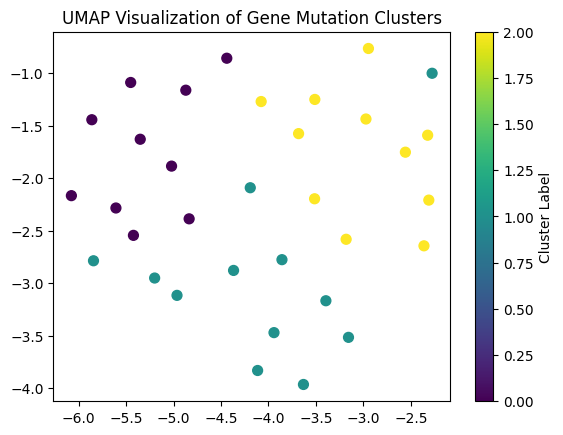

In [30]:
import umap.umap_ as umap
import matplotlib.pyplot as plt

# Reduce dimensionality with UMAP
umap_reducer = umap.UMAP(n_components=2, random_state=42)
reduced_vectors = umap_reducer.fit_transform(normalized_vectors)

# Plot the clusters
plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], c=cluster_labels, cmap='viridis', s=50)
plt.title("UMAP Visualization of Gene Mutation Clusters")
plt.colorbar(label="Cluster Label")
plt.show()

# An experiment to improve the clustering

In [7]:
import re
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.neighbors import NearestNeighbors
from collections import Counter
import pandas as pd

from transformers import AutoTokenizer, AutoModel
import torch

class ImprovedTrialClustering:
    def __init__(self, model_name, tokenizer, model):
        self.tokenizer = tokenizer
        self.model = model
        self.biomarker_keywords = {
            'EGFR': ['egfr', 'epidermal growth factor receptor', 'erlotinib', 'gefitinib', 'osimertinib', 
                     'afatinib', 'dacomitinib', 'exon 19', 'exon 21', 't790m', 'l858r'],
            'KRAS': ['kras', 'kirsten rat sarcoma', 'g12c', 'g12d', 'g12v', 'sotorasib', 'adagrasib',
                     'amg 510', 'mrtx849', 'krasg12c'],
            'ROS1': ['ros1', 'c-ros oncogene 1', 'crizotinib', 'ceritinib', 'alectinib', 'entrectinib',
                     'lorlatinib', 'ros1 fusion', 'ros1 rearrangement']
        }
    
    def extract_biomarker_mentions(self, text):
        """Extract and count biomarker mentions from text"""
        text_lower = text.lower()
        biomarker_counts = {}
        
        for biomarker, keywords in self.biomarker_keywords.items():
            count = sum(text_lower.count(keyword) for keyword in keywords)
            biomarker_counts[biomarker] = count
            
        return biomarker_counts
    
    def preprocess_text_enhanced(self, content, focus_biomarker=None):
        """Enhanced preprocessing with biomarker-specific focus"""
        # Extract relevant fields
        if 'protocolSection' in content:
            content = content['protocolSection']
            eligibility = content.get('eligibilityModule', {}).get('eligibilityCriteria', '')
            conditions = content.get('conditionsModule', {}).get('conditions', [])
            if isinstance(conditions, list):
                conditions = ' '.join(conditions)
            brief_title = content.get('identificationModule', {}).get('briefTitle', '')
            brief_summary = content.get('descriptionModule', {}).get('briefSummary', '')
            detailed_description = content.get('descriptionModule', {}).get('detailedDescription', '')
            intervention_desc = content.get('armsInterventionsModule', {}).get('interventions', [])
            if isinstance(intervention_desc, list):
                intervention_desc = ' '.join([str(i.get('description', '')) for i in intervention_desc])
        else:
            eligibility = content.get('eligibility_criteria', '')
            conditions = content.get('conditions', '')
            brief_title = content.get('brief_title', '')
            brief_summary = content.get('brief_summary', '')
            detailed_description = content.get('detailed_description', '')
            intervention_desc = content.get('intervention_description', '')

        # Create biomarker-focused text segments
        biomarker_relevant_text = self.extract_biomarker_segments(
            eligibility + ' ' + brief_summary + ' ' + brief_title + ' ' + intervention_desc,
            focus_biomarker
        )
        
        # Combine with conditions but weight biomarker-relevant content more
        if focus_biomarker:
            combined_text = f"{focus_biomarker} " * 2 + f"{biomarker_relevant_text} {conditions} {brief_summary}"
        else:
            combined_text = f"{biomarker_relevant_text} {conditions} {brief_summary}"
            
        return combined_text.strip()
    
    def extract_biomarker_segments(self, text, focus_biomarker=None):
        """Extract text segments most relevant to biomarkers"""
        sentences = re.split(r'[.!?]+', text)
        relevant_sentences = []
        
        if focus_biomarker and focus_biomarker in self.biomarker_keywords:
            keywords = self.biomarker_keywords[focus_biomarker]
            for sentence in sentences:
                sentence_lower = sentence.lower()
                if any(keyword in sentence_lower for keyword in keywords):
                    relevant_sentences.append(sentence.strip())
        else:
            # Extract any biomarker-relevant sentences
            all_keywords = []
            for keywords in self.biomarker_keywords.values():
                all_keywords.extend(keywords)
            
            for sentence in sentences:
                sentence_lower = sentence.lower()
                if any(keyword in sentence_lower for keyword in all_keywords):
                    relevant_sentences.append(sentence.strip())
        
        return ' '.join(relevant_sentences) if relevant_sentences else text
    
    def encode_text_with_sliding_window(self, text, max_length=512, stride=256):
        """Enhanced encoding with better aggregation"""
        if not text.strip():
            # Return zero vector for empty text
            return np.zeros(512)  # Assuming 768 dim for BERT models
            
        inputs = self.tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            padding=True,
            max_length=max_length,
            stride=stride,
            return_overflowing_tokens=True,
            return_offsets_mapping=False,
        )
        
        input_ids = inputs["input_ids"]
        attention_mask = inputs["attention_mask"]
        
        with torch.no_grad():
            outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        
        # Weighted mean pooling based on attention
        chunk_embeddings = outputs.last_hidden_state
        attention_weights = attention_mask.unsqueeze(-1).float()
        
        # Apply attention-weighted pooling for each chunk
        weighted_embeddings = (chunk_embeddings * attention_weights).sum(dim=1) / attention_weights.sum(dim=1)
        
        # Aggregate across chunks with more weight on first chunk (usually most important)
        chunk_weights = np.array([1.0] + [0.7] * (len(weighted_embeddings) - 1))
        chunk_weights = chunk_weights / chunk_weights.sum()
        
        aggregated_embedding = np.average(weighted_embeddings.numpy(), axis=0, weights=chunk_weights)
        return aggregated_embedding
    
    def create_multi_representation_vectors(self, json_contents, gene_mutations):
        """Create multiple representations for better clustering"""
        vectors_dict = {
            'biomarker_focused': [],
            'clinical_focused': [],
            'combined': []
        }
        
        for idx, content in enumerate(json_contents):
            focus_biomarker = gene_mutations[idx] if idx < len(gene_mutations) else None
            
            # Biomarker-focused representation
            biomarker_text = self.preprocess_text_enhanced(content, focus_biomarker)
            biomarker_vec = self.encode_text_with_sliding_window(biomarker_text)
            
            # Clinical-focused representation (eligibility + conditions)
            clinical_text = self.extract_clinical_text(content)
            clinical_vec = self.encode_text_with_sliding_window(clinical_text)
            
            # Combined representation (weighted average)
            combined_vec = 0.6 * biomarker_vec + 0.4 * clinical_vec
            
            vectors_dict['biomarker_focused'].append(biomarker_vec)
            vectors_dict['clinical_focused'].append(clinical_vec)
            vectors_dict['combined'].append(combined_vec)
        
        return {k: np.array(v) for k, v in vectors_dict.items()}
    
    def extract_clinical_text(self, content):
        """Extract clinical information without biomarker bias"""
        if 'protocolSection' in content:
            content = content['protocolSection']
            eligibility = content.get('eligibilityModule', {}).get('eligibilityCriteria', '')
            conditions = content.get('conditionsModule', {}).get('conditions', [])
            if isinstance(conditions, list):
                conditions = ' '.join(conditions)
        else:
            eligibility = content.get('eligibility_criteria', '')
            conditions = content.get('conditions', '')
        
        return f"{eligibility} {conditions}".strip()
    
    def hierarchical_clustering_by_biomarker(self, json_contents, gene_mutations, similarity_threshold=0.8):
        """Perform hierarchical clustering within each biomarker group"""
        biomarker_groups = {}
        
        # Group trials by biomarker
        for idx, biomarker in enumerate(gene_mutations):
            if biomarker not in biomarker_groups:
                biomarker_groups[biomarker] = []
            biomarker_groups[biomarker].append(idx)
        
        all_clusters = []
        cluster_metadata = []
        
        for biomarker, indices in biomarker_groups.items():
            if len(indices) < 2:
                continue
                
            # Extract vectors for this biomarker group
            biomarker_contents = [json_contents[i] for i in indices]
            biomarker_mutations = [gene_mutations[i] for i in indices]
            
            vectors_dict = self.create_multi_representation_vectors(biomarker_contents, biomarker_mutations)
            
            # Use combined representation for clustering
            vectors = vectors_dict['combined']
            vectors_normalized = self.normalize_vectors(vectors)
            
            # Compute similarity matrix
            similarity_matrix = cosine_similarity(vectors_normalized)
            
            # Form tight clusters based on similarity threshold
            clusters = self.form_tight_clusters(similarity_matrix, similarity_threshold)
            
            # Map back to original indices and store
            for cluster in clusters:
                if len(cluster) >= 3:  # Minimum cluster size
                    original_cluster = [indices[i] for i in cluster]
                    all_clusters.append(original_cluster)
                    cluster_metadata.append({
                        'biomarker': biomarker,
                        'size': len(cluster),
                        'avg_similarity': np.mean([similarity_matrix[i, j] for i in cluster for j in cluster if i != j])
                    })
        
        return all_clusters, cluster_metadata
    
    def form_tight_clusters(self, similarity_matrix, threshold=0.8):
        """Form tight clusters based on similarity threshold"""
        n = len(similarity_matrix)
        clusters = []
        used = set()
        
        for i in range(n):
            if i in used:
                continue
                
            cluster = [i]
            used.add(i)
            
            # Find all similar trials
            for j in range(i + 1, n):
                if j in used:
                    continue
                    
                # Check if j is similar to all trials in current cluster
                if all(similarity_matrix[j, k] >= threshold for k in cluster):
                    cluster.append(j)
                    used.add(j)
            
            clusters.append(cluster)
        
        return clusters
    
    def normalize_vectors(self, vectors):
        """Normalize vectors for cosine similarity"""
        norms = np.linalg.norm(vectors, axis=1, keepdims=True)
        norms[norms == 0] = 1  # Avoid division by zero
        return vectors / norms
    
    def evaluate_cluster_quality(self, vectors, labels):
        """Evaluate clustering quality metrics"""
        unique_labels = np.unique(labels)
        metrics = {}
        
        for label in unique_labels:
            if label == -1:  # Skip noise points in DBSCAN
                continue
                
            cluster_indices = np.where(labels == label)[0]
            if len(cluster_indices) < 2:
                continue
                
            cluster_vectors = vectors[cluster_indices]
            
            # Intra-cluster similarity
            similarities = cosine_similarity(cluster_vectors)
            avg_similarity = np.mean(similarities[np.triu_indices_from(similarities, k=1)])
            
            metrics[f'cluster_{label}'] = {
                'size': len(cluster_indices),
                'avg_intra_similarity': avg_similarity,
                'indices': cluster_indices.tolist()
            }
        
        return metrics

# Usage example:
def run_improved_clustering(json_contents, gene_mutations, tokenizer, model):
    clustering = ImprovedTrialClustering(None, tokenizer, model)
    
    # Method 1: Hierarchical clustering by biomarker
    clusters, metadata = clustering.hierarchical_clustering_by_biomarker(
        json_contents, gene_mutations, similarity_threshold=0.75
    )
    
    print(f"Found {len(clusters)} tight clusters:")
    for i, (cluster, meta) in enumerate(zip(clusters, metadata)):
        print(f"Cluster {i}: {meta['biomarker']} - Size: {meta['size']}, Avg similarity: {meta['avg_similarity']:.3f}")
    
    # Method 2: Multi-representation approach
    vectors_dict = clustering.create_multi_representation_vectors(json_contents, gene_mutations)
    
    """ # Compare different representations
    for rep_type, vectors in vectors_dict.items():
        vectors_norm = clustering.normalize_vectors(vectors)
        
        # DBSCAN clustering
        dbscan = DBSCAN(eps=0.3, min_samples=3, metric='cosine')
        labels = dbscan.fit_predict(vectors_norm)
        
        # Evaluate quality
        quality_metrics = clustering.evaluate_cluster_quality(vectors_norm, labels)
        
        print(f"\n{rep_type.upper()} representation:")
        print(f"Number of clusters: {len(set(labels)) - (1 if -1 in labels else 0)}")
        print(f"Noise points: {sum(1 for l in labels if l == -1)}")
        
        for cluster_id, metrics in quality_metrics.items():
            print(f"  {cluster_id}: size={metrics['size']}, similarity={metrics['avg_intra_similarity']:.3f}") 
    """
    
    return clusters, metadata, vectors_dict

In [8]:
clusters, metadata, vectors_dict = run_improved_clustering(json_contents, gene_mutations, tokenizer, model)


Found 3 tight clusters:
Cluster 0: KRAS - Size: 11, Avg similarity: 0.981
Cluster 1: EGFR - Size: 11, Avg similarity: 0.982
Cluster 2: ROS1 - Size: 11, Avg similarity: 0.989


In [9]:
import umap
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity

def visualize_hierarchical_clusters(vectors, clusters, metadata, gene_mutations, save_path=None):
    """
    Create UMAP visualization for hierarchical clustering results.
    
    Args:
        vectors: Single vector representation used for clustering
        clusters: List of cluster indices from hierarchical clustering
        metadata: Cluster metadata from hierarchical clustering
        gene_mutations: Original biomarker labels
        save_path: Optional path to save the figure
    """
    
    # Create cluster labels for all trials
    cluster_labels = np.full(len(gene_mutations), -1)  # Initialize with -1 (unclustered)
    
    for cluster_id, cluster_indices in enumerate(clusters):
        for idx in cluster_indices:
            cluster_labels[idx] = cluster_id
    
    # Encode biomarker labels for coloring
    le = LabelEncoder()
    biomarker_encoded = le.fit_transform(gene_mutations)
    biomarker_names = le.classes_
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle('UMAP Visualization of Hierarchical Clustering Results', fontsize=16)
    
    colors = ['purple', 'teal', 'gold']  # Colors for different biomarkers
    
    # Apply UMAP
    reducer = umap.UMAP(
        n_neighbors=15,
        min_dist=0.1,
        n_components=2,
        metric='cosine',
        random_state=42
    )
    
    embedding = reducer.fit_transform(vectors)
    
    # Left subplot: Colored by biomarker
    for biomarker_idx, biomarker_name in enumerate(biomarker_names):
        mask = biomarker_encoded == biomarker_idx
        ax1.scatter(
            embedding[mask, 0], 
            embedding[mask, 1],
            c=colors[biomarker_idx % len(colors)],
            label=f'{biomarker_name}',
            alpha=0.7,
            s=80,
            edgecolors='white',
            linewidth=0.5
        )
    
    # Add cluster boundaries
    for cluster_id, cluster_indices in enumerate(clusters):
        cluster_embedding = embedding[cluster_indices]
        # Draw a convex hull around each cluster
        if len(cluster_indices) >= 3:  # Need at least 3 points for hull
            try:
                from scipy.spatial import ConvexHull
                hull = ConvexHull(cluster_embedding)
                for simplex in hull.simplices:
                    ax1.plot(cluster_embedding[simplex, 0], 
                           cluster_embedding[simplex, 1], 
                           'k--', alpha=0.5, linewidth=1)
            except:
                pass  # Skip if ConvexHull fails
    
    ax1.set_title('Clusters by Biomarker')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Right subplot: Colored by cluster ID
    unique_cluster_labels = [i for i in range(len(clusters))]
    cluster_colors = plt.cm.Set1(np.linspace(0, 1, len(clusters)))
    
    for cluster_id, cluster_indices in enumerate(clusters):
        cluster_embedding = embedding[cluster_indices]
        ax2.scatter(
            cluster_embedding[:, 0],
            cluster_embedding[:, 1],
            c=[cluster_colors[cluster_id]],
            label=f'Cluster {cluster_id} ({metadata[cluster_id]["biomarker"]})',
            alpha=0.7,
            s=80,
            edgecolors='white',
            linewidth=0.5
        )
    
    # Mark unclustered points if any
    unclustered_mask = cluster_labels == -1
    if np.any(unclustered_mask):
        ax2.scatter(
            embedding[unclustered_mask, 0],
            embedding[unclustered_mask, 1],
            c='gray',
            label='Unclustered',
            alpha=0.5,
            s=40
        )
    
    ax2.set_title('Clusters by Hierarchy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    # Print cluster statistics
    print("=== CLUSTER STATISTICS ===")
    for i, (cluster_indices, meta) in enumerate(zip(clusters, metadata)):
        print(f"Cluster {i}: {meta['biomarker']}")
        print(f"  Size: {meta['size']}")
        print(f"  Avg Similarity: {meta['avg_similarity']:.3f}")
        print(f"  Trial indices: {cluster_indices}")
        print()
    
    # Overall statistics
    total_clustered = sum(len(cluster) for cluster in clusters)
    total_trials = len(gene_mutations)
    
    print(f"Summary:")
    print(f"  Total trials: {total_trials}")
    print(f"  Clustered trials: {total_clustered}")
    print(f"  Coverage: {total_clustered/total_trials*100:.1f}%")
    print(f"  Number of clusters: {len(clusters)}")
    
    return embedding

def analyze_cluster_separation(vectors, clusters, metadata):
    """
    Analysis of how well separated the hierarchical clusters are by using intra and inter cluster distances and similarity.
    """
    print("\n=== CLUSTER SEPARATION ANALYSIS ===\n")
    
    # Normalize vectors for cosine similarity
    norms = np.linalg.norm(vectors, axis=1, keepdims=True)
    norms[norms == 0] = 1  # Avoid division by zero
    vectors_norm = vectors / norms
    
    # Calculate cluster centroids
    cluster_centroids = []
    for cluster_indices in clusters:
        cluster_vectors = vectors_norm[cluster_indices]
        centroid = np.mean(cluster_vectors, axis=0)
        cluster_centroids.append(centroid)
    
    # Calculate inter-cluster similarities
    if len(cluster_centroids) > 1:
        centroid_similarities = cosine_similarity(cluster_centroids)
        
        print("Inter-cluster similarities (centroid-to-centroid):")
        for i, meta_i in enumerate(metadata):
            for j, meta_j in enumerate(metadata):
                if i < j:  # Only upper triangle
                    sim = centroid_similarities[i, j]
                    print(f"  {meta_i['biomarker']} <-> {meta_j['biomarker']}: {sim:.3f}")
    
    # Calculate within vs between cluster statistics
    print(f"\nIntra vs Inter-cluster analysis:")
    for i, (cluster_indices, meta) in enumerate(zip(clusters, metadata)):
        cluster_vectors = vectors_norm[cluster_indices]
        
        # Intra-cluster similarity
        if len(cluster_vectors) > 1:
            intra_similarities = cosine_similarity(cluster_vectors)
            # Take mean of upper triangle (excluding diagonal)
            mask = np.triu(np.ones_like(intra_similarities, dtype=bool), k=1)
            intra_sim = np.mean(intra_similarities[mask])
        else:
            intra_sim = 1.0
        
        # Inter-cluster similarity (to all other clusters)
        inter_sims = []
        for j, other_cluster_indices in enumerate(clusters):
            if i != j:
                other_vectors = vectors_norm[other_cluster_indices]
                inter_sim_matrix = cosine_similarity(cluster_vectors, other_vectors)
                inter_sims.append(np.mean(inter_sim_matrix))
        
        min_inter_sim = min(inter_sims) if inter_sims else 0.0
        avg_inter_sim = np.mean(inter_sims) if inter_sims else 0.0
        
        separation_score = intra_sim - avg_inter_sim
        print(f"  {meta['biomarker']}: intra={intra_sim:.3f}, "
              f"inter_avg={avg_inter_sim:.3f}, inter_min={min_inter_sim:.3f}, "
              f"separation={separation_score:.3f}")

# Simple usage function
def create_umap_visualization(vectors, clusters, metadata, gene_mutations, save_path=None):
    """
    Simple wrapper to create visualization and analysis
    
    Args:
        vectors: Embedding vectors (from hierarchical clustering)
        clusters: Cluster indices from hierarchical_clustering_by_biomarker()
        metadata: Metadata from hierarchical_clustering_by_biomarker()
        gene_mutations: List of biomarker labels
        save_path: Optional path to save figure
    """
    
    embedding = visualize_hierarchical_clusters(
        vectors, clusters, metadata, gene_mutations, save_path
    )
    
    analyze_cluster_separation(vectors, clusters, metadata)
    
    return embedding

/scratch/mgeorges/conda_envs/unsloth_env/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


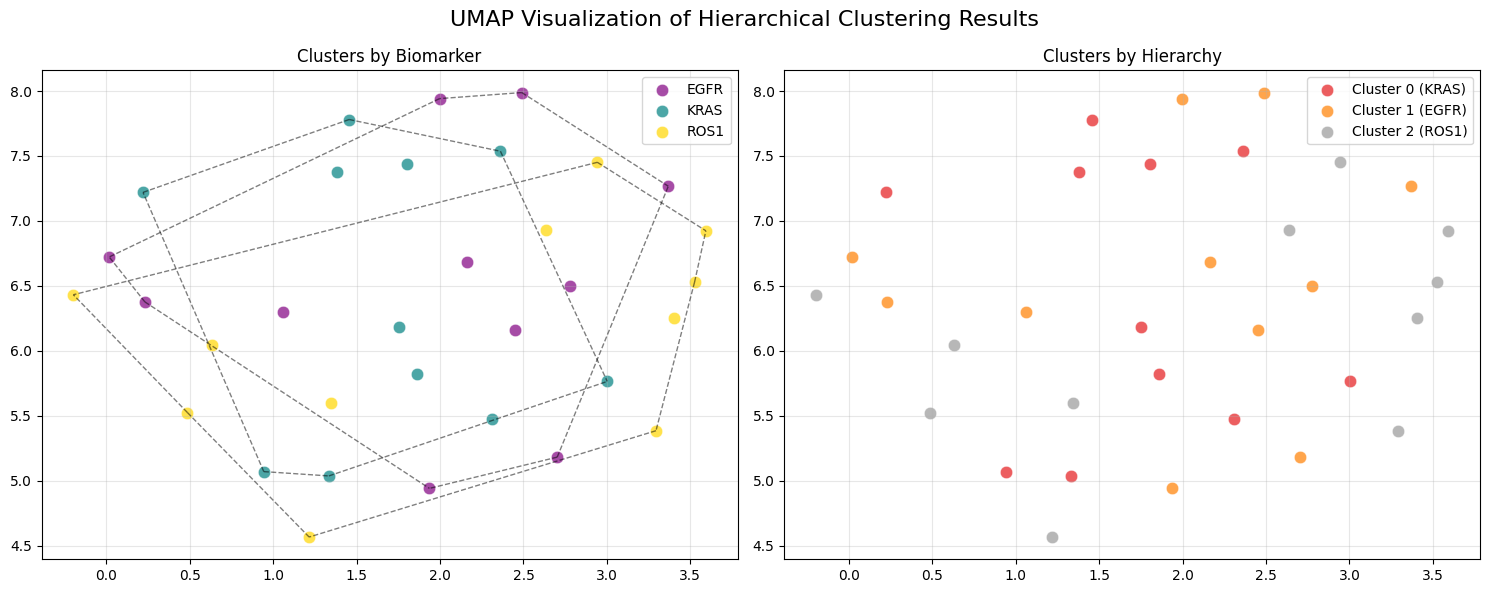

=== CLUSTER STATISTICS ===
Cluster 0: KRAS
  Size: 11
  Avg Similarity: 0.981
  Trial indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

Cluster 1: EGFR
  Size: 11
  Avg Similarity: 0.982
  Trial indices: [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]

Cluster 2: ROS1
  Size: 11
  Avg Similarity: 0.989
  Trial indices: [22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]

Summary:
  Total trials: 33
  Clustered trials: 33
  Coverage: 100.0%
  Number of clusters: 3

=== CLUSTER SEPARATION ANALYSIS ===

Inter-cluster similarities (centroid-to-centroid):
  KRAS <-> EGFR: 0.997
  KRAS <-> ROS1: 0.997
  EGFR <-> ROS1: 0.998

Intra vs Inter-cluster analysis:
  KRAS: intra=0.981, inter_avg=0.982, inter_min=0.981, separation=-0.001
  EGFR: intra=0.982, inter_avg=0.983, inter_min=0.981, separation=-0.000
  ROS1: intra=0.989, inter_avg=0.984, inter_min=0.983, separation=0.005


In [ ]:
# Create the vectors you used for clustering if not already done (probably keep the 'combined' representation)
# clustering = ImprovedTrialClustering(None, tokenizer, model)
# vectors_dict = clustering.create_multi_representation_vectors(json_contents, gene_mutations)
vectors = vectors_dict['combined']  # Or whichever representation used

# Create UMAP visualization
embedding = create_umap_visualization(
    vectors, clusters, metadata, gene_mutations, 
    save_path="hierarchical_clusters_umap.png"
)

In [10]:
print(clusters)

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21], [22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]]


In [ ]:
# Save clusters and metadata to CSV
def save_clusters_to_csv(clusters, metadata, gene_mutations, filename="clusters_metadata.csv"):
    """
    Save clusters and their metadata to a CSV file.
    
    Args:
        clusters: List of cluster indices
        metadata: List of metadata dictionaries
        gene_mutations: Original biomarker labels
        filename: Output CSV filename
    """
    rows = []
    for cluster_id, (cluster_indices, meta) in enumerate(zip(clusters, metadata)):
        for idx in cluster_indices:
            rows.append({
                'Trial NCT ID': nct_ids[idx],
                'Cluster ID': cluster_id,
                'Biomarker': meta['biomarker'],
                'Trial Index': idx,
                'Gene Mutation': gene_mutations[idx]
            })
    
    df = pd.DataFrame(rows)
    df.to_csv(filename, index=False)
    print(f"Clusters and metadata saved to {filename}")

# Save to CSV
save_clusters_to_csv(clusters, metadata, gene_mutations, filename="../../data/clusters_metadata.csv")

# Generation of Ideal Patients Dataset (Using Llama 3 8B Instruct)

In [ ]:
from transformers import pipeline
import os
import json
import random
from typing import List, Dict
import sys
sys.path.append('../../')  # Adjust path as needed to import from parent directory
from utils.gpt.gpt_generate_ideal_candidates import (
    extract_age_gender_from_summary,
      extract_main_condition_from_summary,
        generate_synonyms,
          generate_conditions,
            split_into_sentences,
              generate_summary
)
from langchain_huggingface import HuggingFacePipeline
from langchain.schema import HumanMessage
# Initialize the language model (e.g., Llama 3-8b)

generator = pipeline(
    "text-generation",
    model="meta-llama/Meta-Llama-3-8B-Instruct",  # or llama3.1/3.3, depending on what you downloaded
    device_map="auto",
    torch_dtype="auto",
    max_new_tokens=512,
)

llm = HuggingFacePipeline(pipeline=generator)

def extract_common_criteria_with_model(trials: List[Dict]) -> str:
    """
    Uses a generative model to extract common inclusion criteria across all trials in a cluster.
    """
    all_criteria = " ".join([trial.get("eligibility_criteria", "") for trial in trials])
    prompt = f"""
    You are a medical expert. Based on the following eligibility criteria from multiple clinical trials, extract the common inclusion criteria that apply to all trials. Provide the output as a concise paragraph.
    Eligibility Criteria: {all_criteria}
    """
    response = llm.invoke([HumanMessage(content=prompt)])
    return response.content.strip()

def generate_cluster_patient_profiles(cluster_trials: List[Dict], cluster_id: str, num_patients: int = 100) -> List[Dict]:
    """
    Generates ideal patient profiles for a cluster of trials.

    Steps:
      1. Extract common inclusion criteria across all trials in the cluster using a generative model.
      2. Randomize patient attributes (age, gender, condition) while ensuring they meet the common criteria.
      3. Generate patient profiles based on the common criteria and randomized attributes.

    Args:
      cluster_trials (List[Dict]): List of trial data dictionaries for the cluster.
      cluster_id (str): Identifier for the cluster.
      num_patients (int): Number of patient profiles to generate.

    Returns:
      List[Dict]: List of generated patient profiles.
    """
    # Combine all eligibility criteria from the trials in the cluster
    all_criteria = " ".join([trial.get("eligibility_criteria", "") for trial in cluster_trials])
    
    # Use the generative model to extract common inclusion criteria
    prompt = f"""
    You are a medical expert. Based on the following eligibility criteria from multiple clinical trials, extract the common inclusion criteria that apply to all trials. Provide the output as a concise paragraph.
    Eligibility Criteria: {all_criteria}
    """
    response = llm.invoke([HumanMessage(content=prompt)])
    common_criteria = response.content.strip()
    print(f"Common criteria for cluster {cluster_id}: {common_criteria}")
    
    # Extract all unique conditions from the trials in the cluster
    all_conditions = list(set(
        trial.get("condition", "") if isinstance(trial.get("condition"), str) else " ".join(trial.get("condition", []))
        for trial in cluster_trials
    ))
    
    # Generate patient profiles
    patients = []
    for i in range(num_patients):
        # Randomize age and gender
        age = random.randint(18, 80)  # Example age range
        gender = random.choice(["male", "female"])
        
        # Randomize condition
        condition = random.choice(all_conditions) if all_conditions else "Condition not specified"
        
        # Generate patient profile
        raw_description = generate_summary(
            details=[common_criteria],
            conditions=[condition],
            age_spec=f"aged {age} years old; gender must be {gender}"
        )
        age, gender = extract_age_gender_from_summary(raw_description)
        main_condition = extract_main_condition_from_summary(raw_description)
        synonyms = generate_synonyms(main_condition)
        conditions_from_note = generate_conditions(raw_description)
        if main_condition not in conditions_from_note:
            conditions = [main_condition] + conditions_from_note
        else:
            conditions = conditions_from_note
        
        patient_profile = {
            "raw_description": raw_description,
            "age": age,
            "gender": gender,
            "main_condition": main_condition,
            "synonyms": synonyms,
            "conditions": conditions,
            "split_raw_description": split_into_sentences(raw_description),
            "ground_nctid": f"Cluster-{cluster_id}-Patient-{i+1}"
        }
        patients.append(patient_profile)
    
    return patients

def process_clusters(cluster_indices: Dict[str, List[str]], trial_folder: str, output_file: str):
    """
    Processes clusters of trials to generate ideal patients for each cluster.
    - `cluster_indices`: A dictionary where keys are cluster IDs and values are lists of trial file names.
    - `trial_folder`: Path to the folder containing trial JSON files.
    - `output_file`: Path to save the generated patient profiles.
    """
    results = {}
    for cluster_id, trial_files in cluster_indices.items():
        print(f"Processing cluster {cluster_id} with {len(trial_files)} trials...")
        
        # Load trials for the cluster
        cluster_trials = []
        for trial_file in trial_files:
            trial_path = os.path.join(trial_folder, trial_file)
            try:
                with open(trial_path, 'r') as f:
                    trial_data = json.load(f)
                    cluster_trials.append(trial_data)
            except Exception as e:
                print(f"Failed to load trial {trial_file}: {e}")
        
        # Generate patients for the cluster
        patients = generate_cluster_patient_profiles(cluster_trials, cluster_id)
        results[cluster_id] = patients
    
    # Save results to the output file
    with open(output_file, 'w') as out_file:
        json.dump(results, out_file, indent=2)
    
    print(f"Processing complete. Results saved to {output_file}")
